<a href="https://colab.research.google.com/github/ayush2281/Pytorch-for-ML-DL-/blob/main/06_pytorch_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

06. PyTorch Transfer Learning

           Note: This notebook uses torchvision's new multi-weight support API
           
           (available in torchvision v0.13+).

We've built a few models by hand so far.

But their performance has been poor.

You might be thinking, is there a well-performing model that already exists for our problem?

And in the world of deep learning, the answer is often yes.

We'll see how by using a powerful technique called** transfer learning.**We've built a few models by hand so far.




What is transfer learning?
**Transfer learning** allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as `ImageNet` (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a `language model `(a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

The premise remains: find a well-performing existing model and apply it to your own problem.

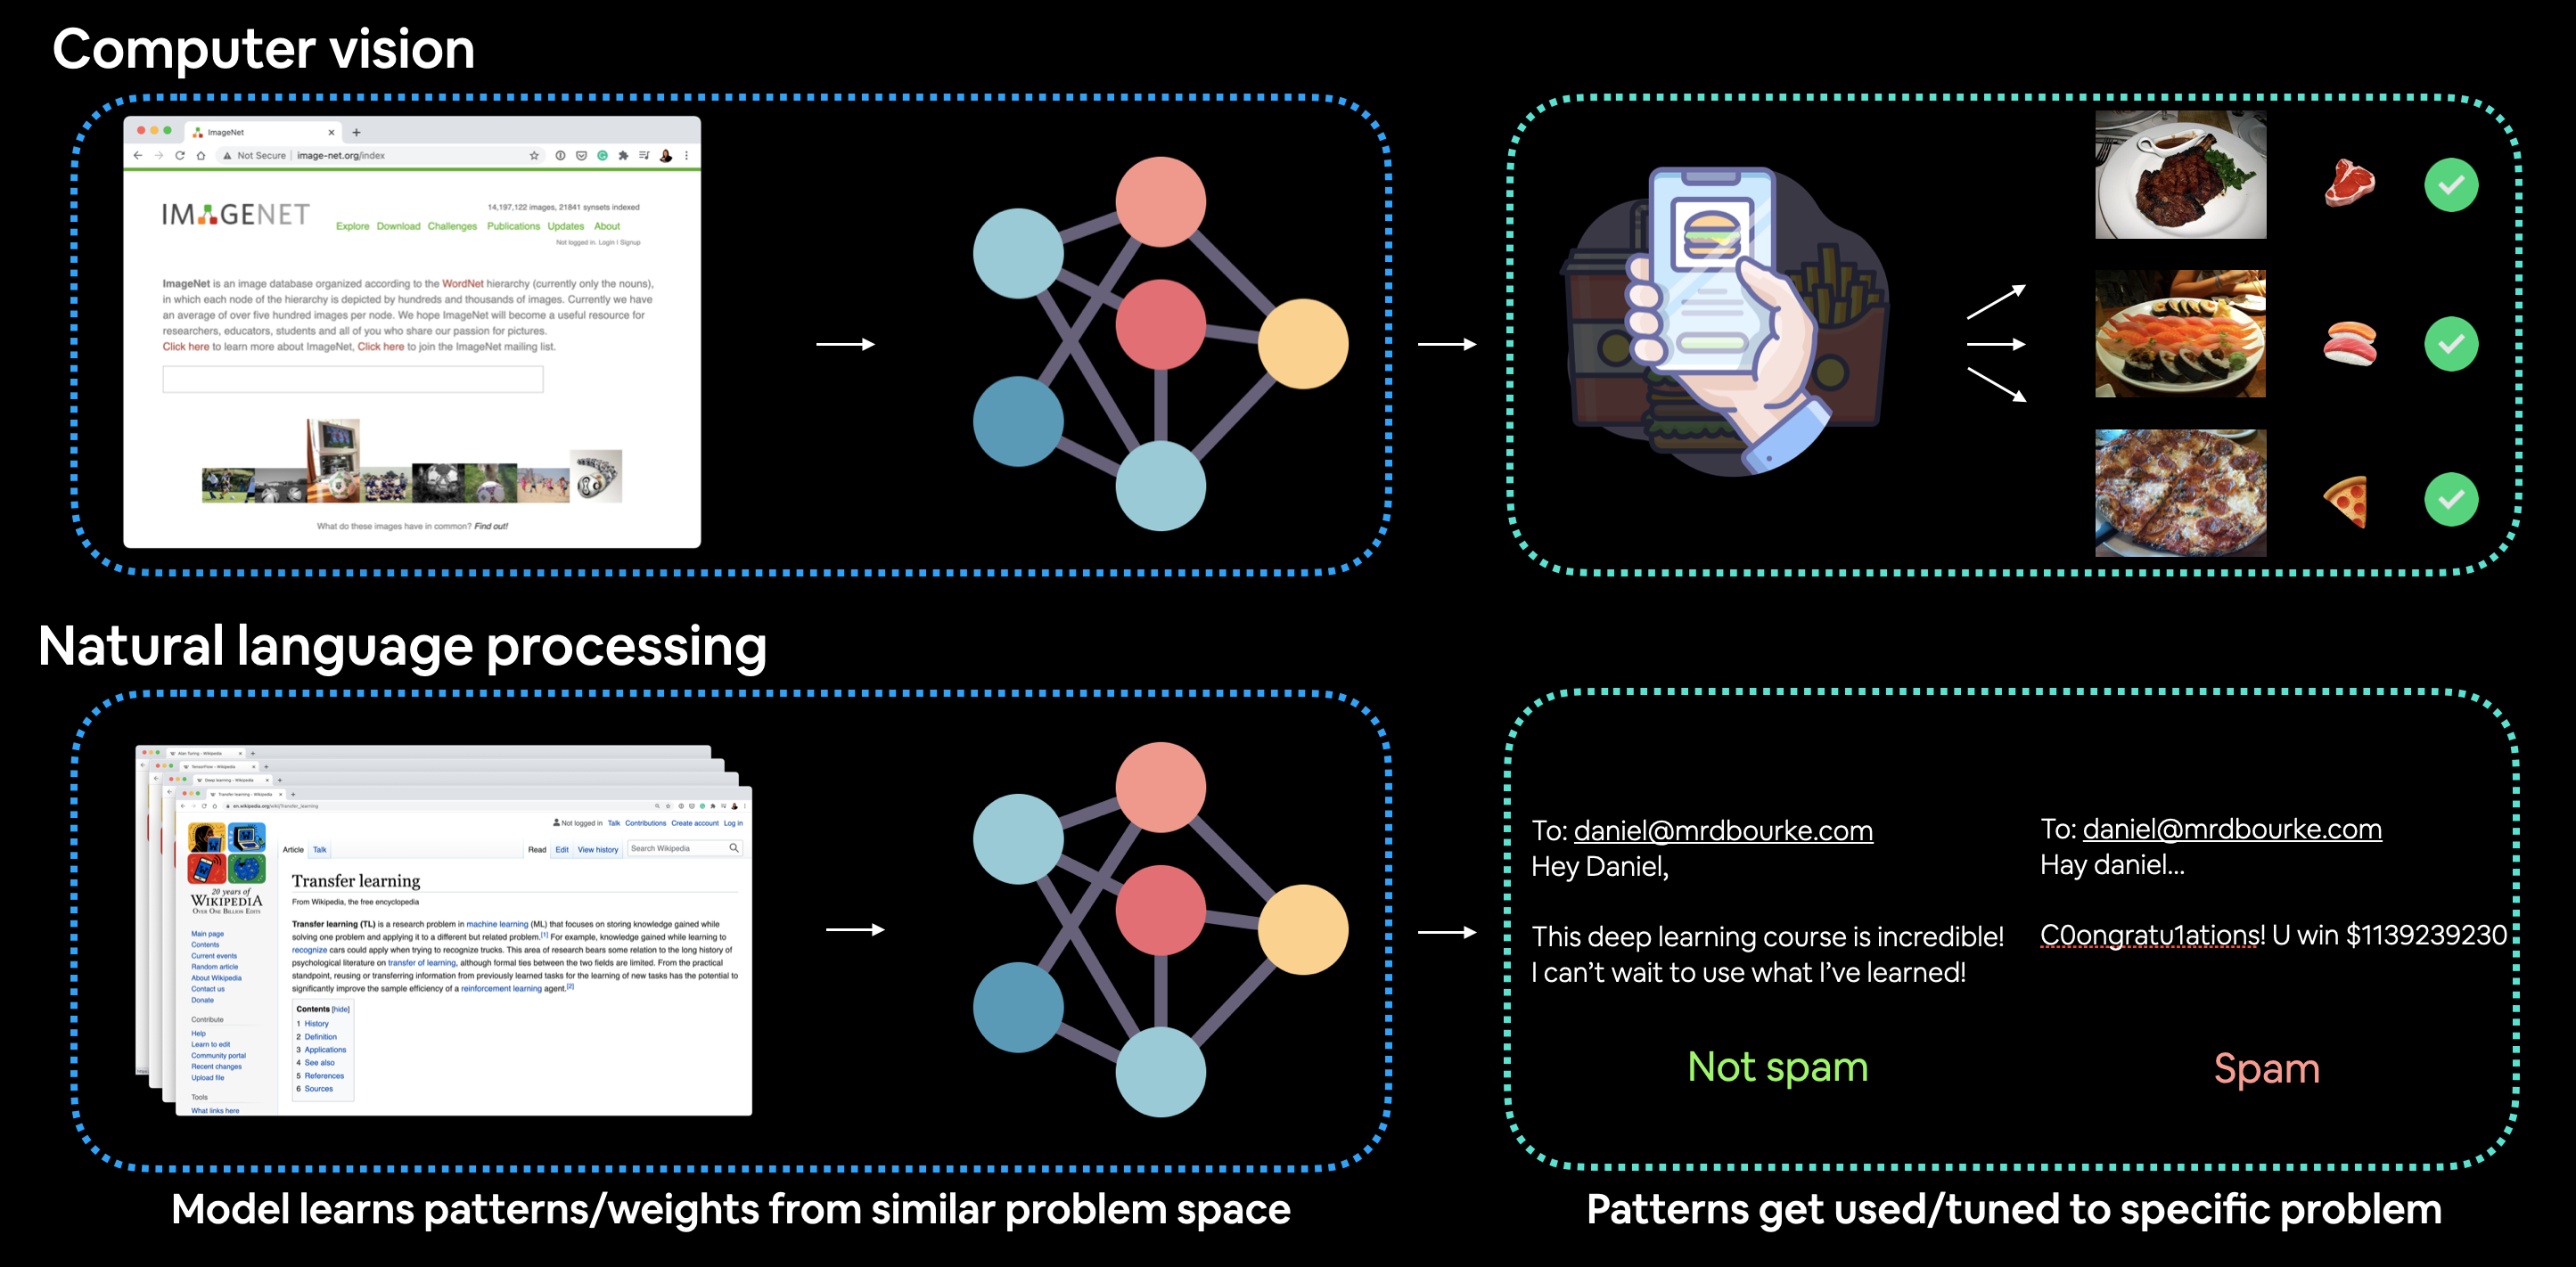

Example of transfer learning being applied to computer vision and natural language processing (NLP). In the case of computer vision, a computer vision model might learn patterns on millions of images in ImageNet and then use those patterns to infer on another problem. And for NLP, a language model may learn the structure of language by reading all of Wikipedia (and perhaps more) and then apply that knowledge to a different problem.

###Why use transfer learning?
There are two main benefits to using transfer learning:

1. Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
2. Can leverage a working model which has **already** learned patterns on similar data to our own. This often results in achieving **great results with less custom data**

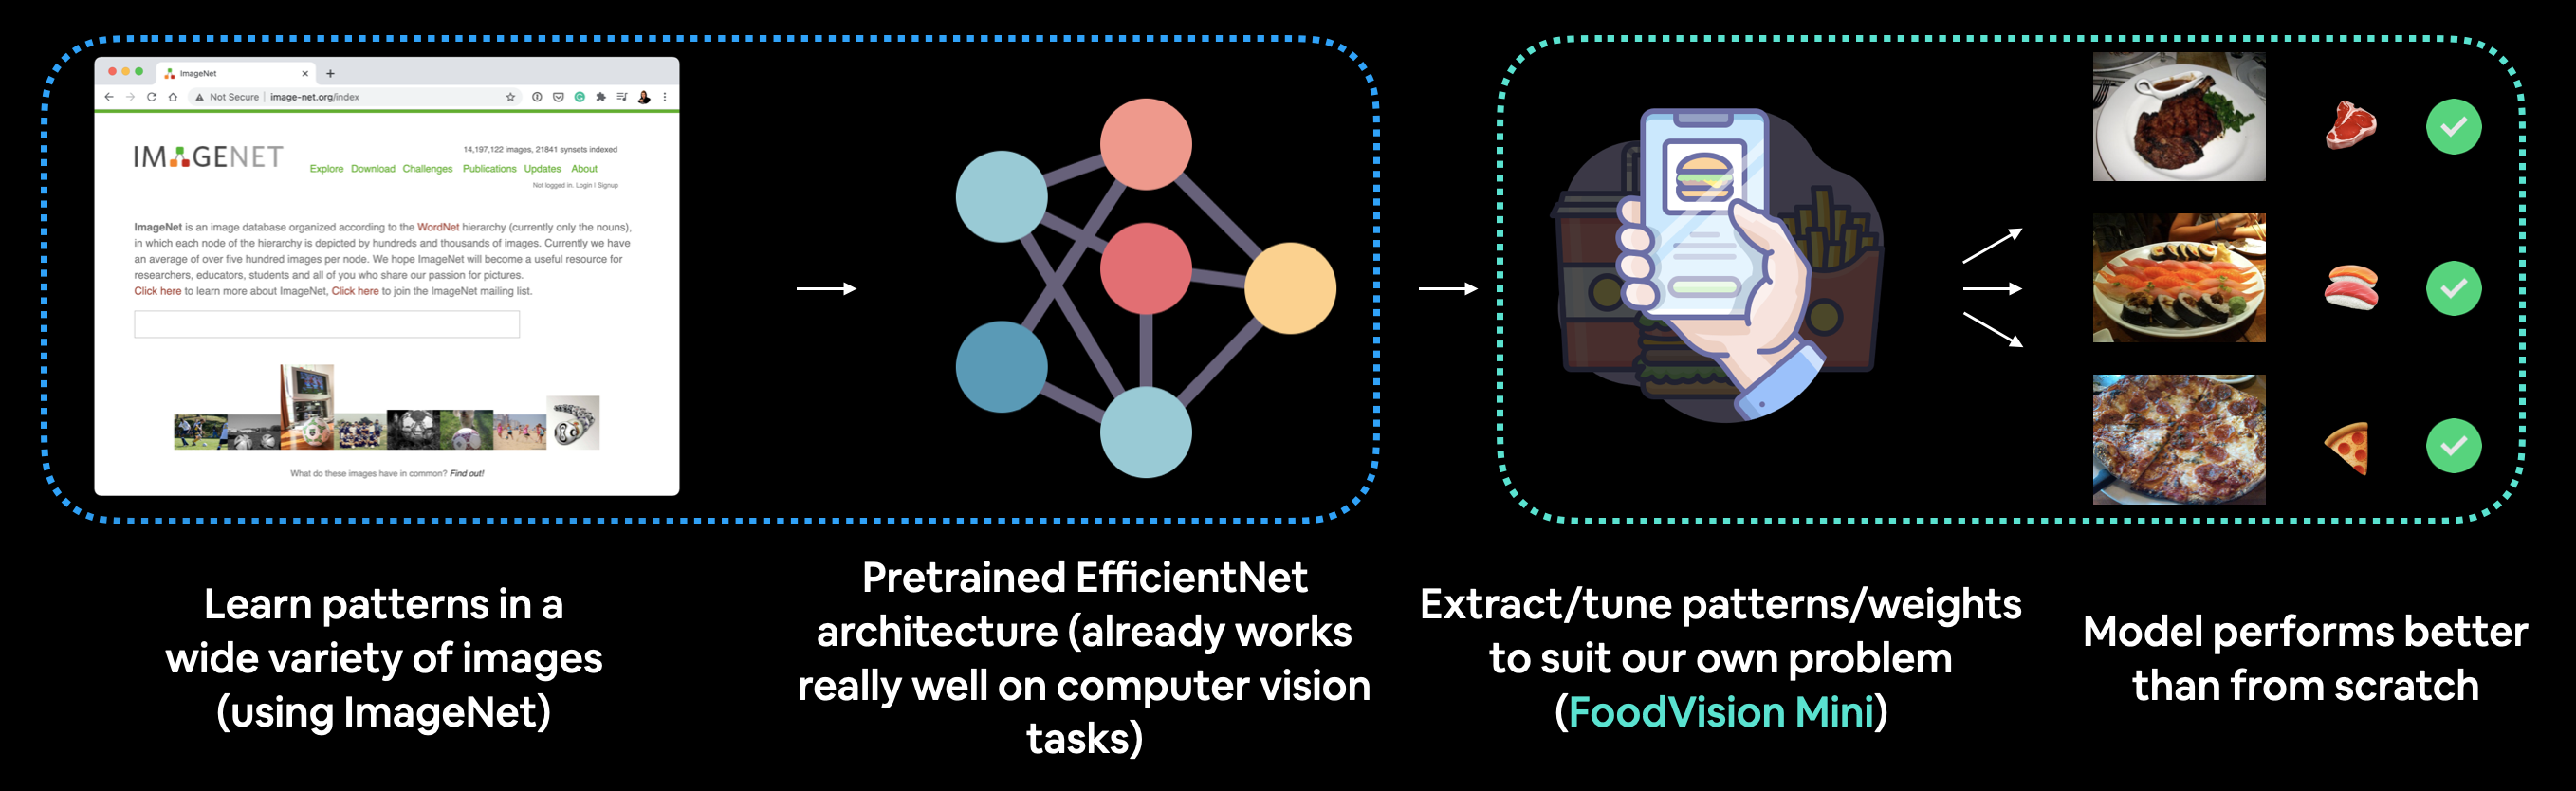

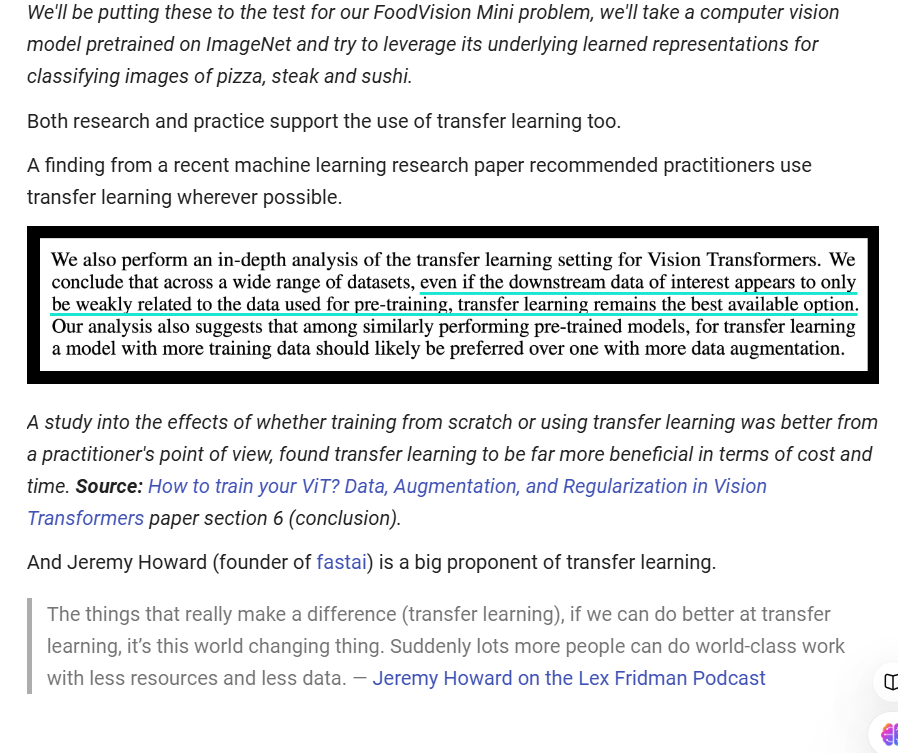

[how to train your vit Data, Augmentation, and Regularization in Vision Transformers](https://arxiv.org/abs/2106.10270)

Where to find pretrained models
The world of deep learning is an amazing place.

So amazing that many people around the world share their work.

Often, code and pretrained models for the latest state-of-the-art research is released within a few days of publishing.

And there are several places you can find pretrained models to use for your own problems.

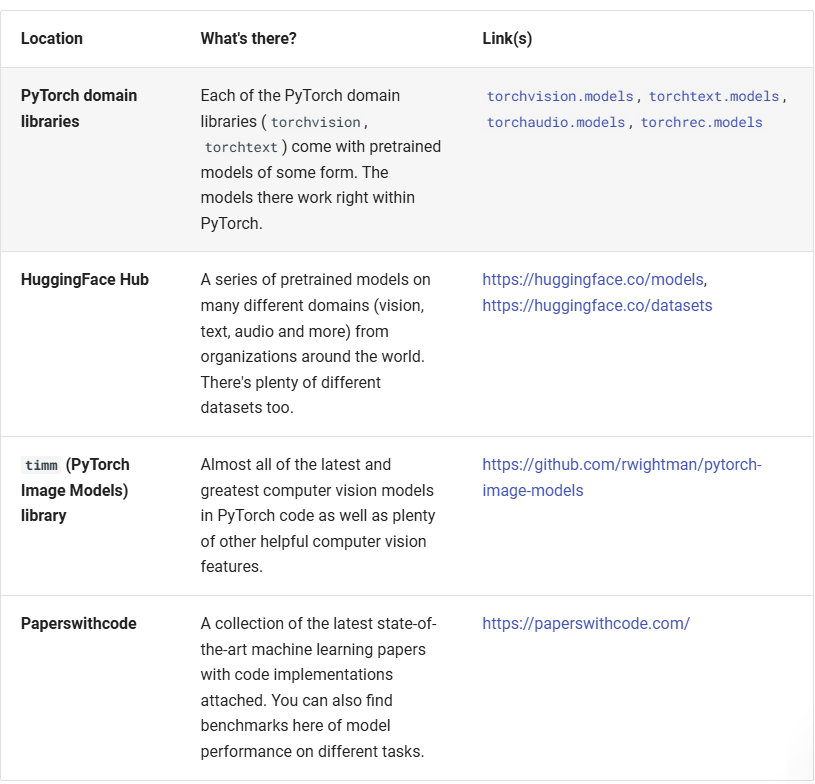

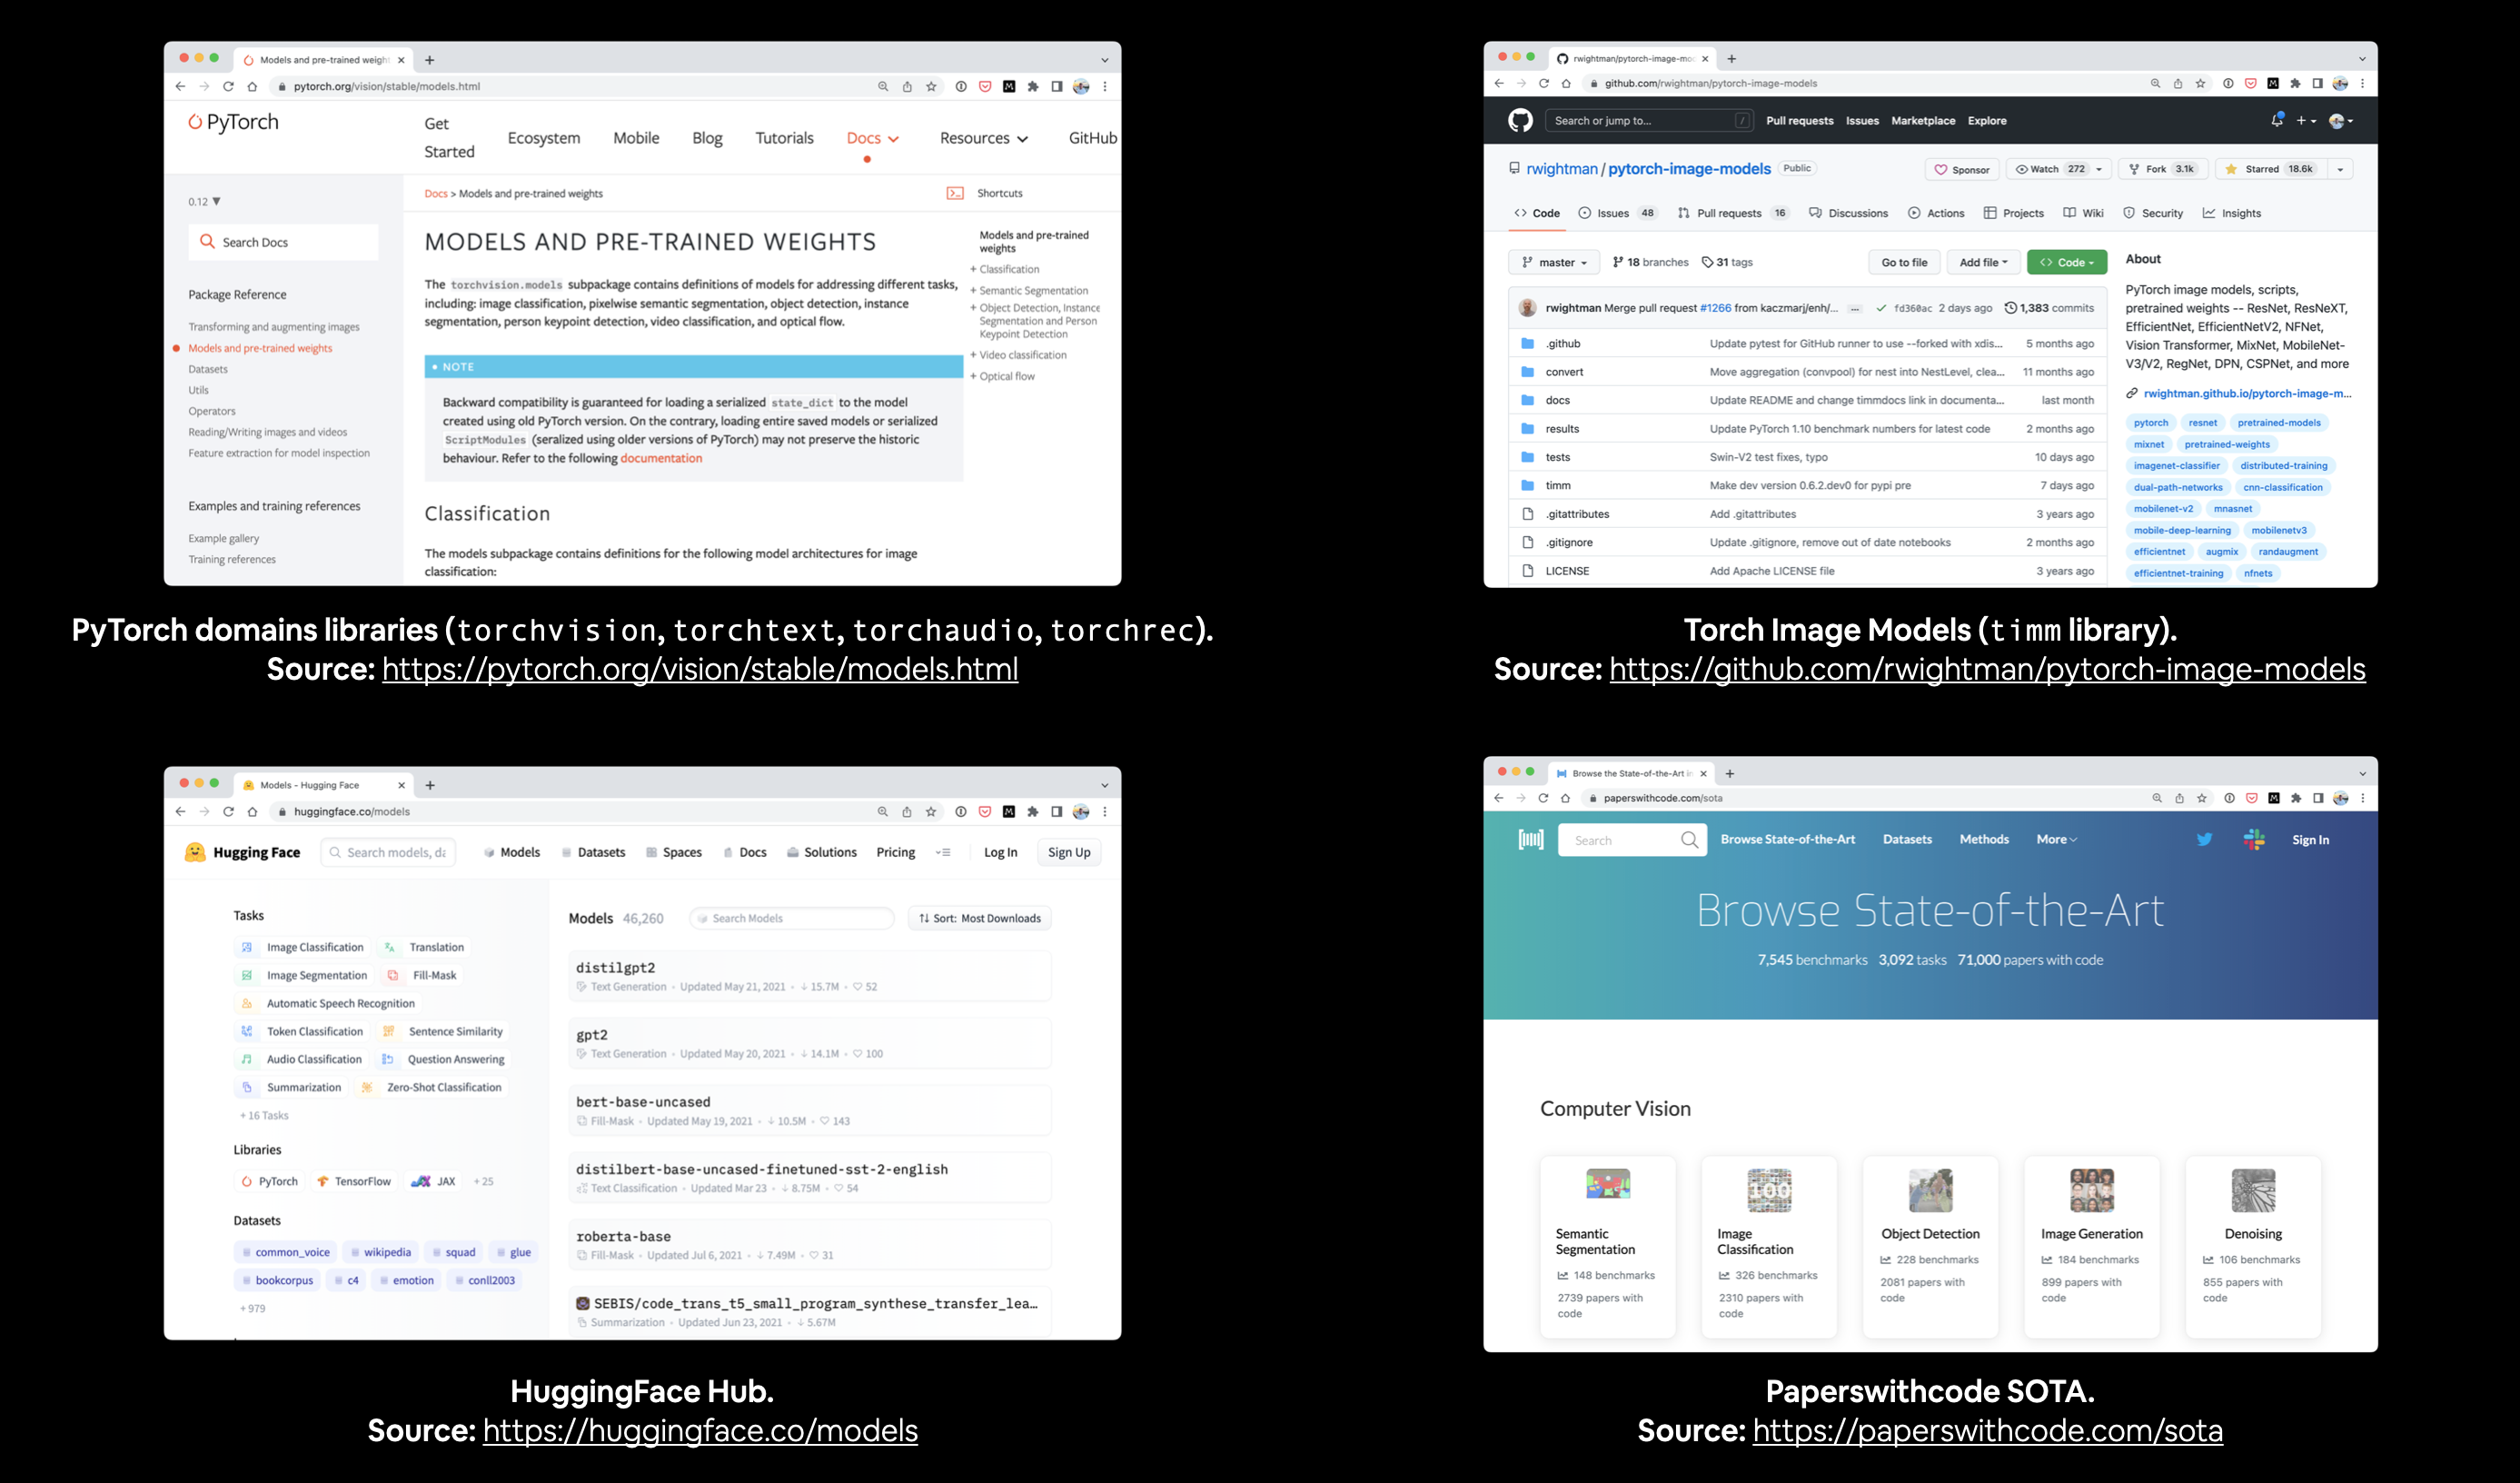

[HuggingFaceHub](https://huggingface.co/models)

With access to such high-quality resources as above, it should be common practice at the start of every deep learning problem you take on to ask, "Does a pretrained model exist for my problem?"

**Exercise**: Spend 5-minutes going through `torchvision.models` as well as the [HuggingFace Hub Models page](https://huggingface.co/models), what do you find? (there's no right answers here, it's just to practice exploring)

What we're going to cover

We're going to take a pretrained model from `torchvision.models` and customise it to work on (and hopefully improve) our FoodVision Mini problem.

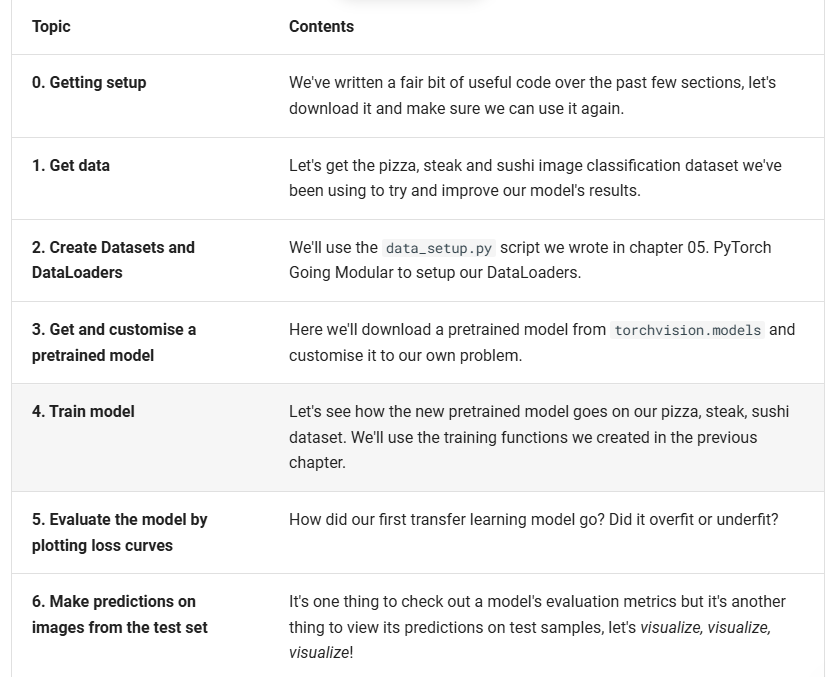


###0. Getting setup
Let's get started by importing/downloading the required modules for this section.

To save us writing extra code, we're going to be leveraging some of the Python scripts (such as data_setup.py and engine.py) we created in the previous section, [05. PyTorch Going Modular] (https://github.com/ayush2281/Pytorch-for-ML-DL-).

Specifically, we're going to download the going_modular directory from the pytorch-deep-learning repository (if we don't already have it).

We'll also get the torchinfo package if it's not available.

torchinfo will help later on to give us a visual representation of our model.

**Note**: As of June 2022, this notebook uses the nightly versions of torch and torchvision as torchvision v0.13+ is required for using the updated multi-weights API. You can install these using the command below.

In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.5.0+cu121
torchvision version: 0.20.0+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 32.59 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


Now let's setup device agnostic code.

**Note**: If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via Runtime -> `Change runtime type -> Hardware accelerator -> GPU.`

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'


###1. Get data¶